# Convolutional Recurrent Neural Network for Text Recognition

In [12]:
import os
import fnmatch
import cv2
import numpy as np
import string
import time
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM
from keras.layers import  Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import cv2
import numpy as np
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

tf.get_logger().setLevel('ERROR')


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3530243563096296590
xla_global_id: -1
]
Device mapping: no known devices.


In [4]:
char_list = string.ascii_letters+string.digits 
def encode_to_labels(txt):
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

In [5]:
import cv2
import os
import fnmatch
import numpy as np


path = 'Train_data/' 


training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []

valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []

max_label_len = 0

i = 1 
flag = 0

for root, dirnames, filenames in os.walk(path):

    for f_name in fnmatch.filter(filenames, '*.jpg'):
        img = cv2.imread(os.path.join(root, f_name), cv2.IMREAD_GRAYSCALE)

        w, h = img.shape
        if h > 128 or w > 32:
            continue
        if w < 32:
            add_zeros = np.ones((32-w, h)) * 255
            img = np.vstack((img, add_zeros))
        if h < 128:
            add_zeros = np.ones((32, 128-h)) * 255
            img = np.hstack((img, add_zeros))
        img = np.expand_dims(img, axis=2)
     
        img = img / 255.
        #txt = f_name.split('_')[1]
        txt = f_name.split('_')[1].replace(".jpg", "")

        
        if len(txt) > max_label_len:
            max_label_len = len(txt)

       
        if i % 10 == 0:     
            valid_orig_txt.append(txt)   
            valid_label_length.append(len(txt))
            valid_input_length.append(31)
            valid_img.append(img)
            valid_txt.append(encode_to_labels(txt))
        else:
            orig_txt.append(txt)   
            train_label_length.append(len(txt))
            train_input_length.append(31)
            training_img.append(img)
            training_txt.append(encode_to_labels(txt)) 

        if i == 50000:
            flag = 1
            break
        i += 1

    if flag == 1:
        break


In [6]:
 
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = len(char_list))
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = len(char_list))

### Network Archtecture

1. Input shape for our architecture having an input image of height 32 and width 128.
2. Here we used seven convolution layers of which 6 are having kernel size (3,3) and the last one is of size (2.2). And the    number of filters is increased from 64 to 512 layer by layer.
3. Two max-pooling layers are added with size (2,2) and then two max-pooling layers of size (2,1) are added to extract        features with a larger width to predict long texts.
4. Also, we used batch normalization layers after fifth and sixth convolution layers which accelerates the training       process.
5. Then we used a lambda function to squeeze the output from conv layer and make it compatible with LSTM layer.
6. Then used two Bidirectional LSTM layers each of which has 128 units. This RNN layer gives the output of size (batch_size, 31, 63). Where 63 is the total number of output classes including blank character.

In [7]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [8]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

### Loss Function

In [9]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

### train the Model

In [10]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
 
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [11]:
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)
valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

In [22]:
batch_size = 256
epochs = 10
  
model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length],
          y=np.zeros(len(training_img)), 
          batch_size=batch_size, epochs = epochs,
          validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], 
          [np.zeros(len(valid_img))]), verbose = 1, callbacks = callbacks_list)

Epoch 1/10
176/176 [==============================] - ETA: 0s - loss: 29.9149
Epoch 1: val_loss improved from inf to 28.29442, saving model to best_model.hdf5
176/176 [==============================] - 1231s 7s/step - loss: 29.9149 - val_loss: 28.2944
Epoch 2/10
176/176 [==============================] - ETA: 0s - loss: 25.9021 
Epoch 2: val_loss did not improve from 28.29442
176/176 [==============================] - 2534s 14s/step - loss: 25.9021 - val_loss: 28.4867
Epoch 3/10
176/176 [==============================] - ETA: 0s - loss: 22.9995
Epoch 3: val_loss improved from 28.29442 to 25.43919, saving model to best_model.hdf5
176/176 [==============================] - 1136s 6s/step - loss: 22.9995 - val_loss: 25.4392
Epoch 4/10
176/176 [==============================] - ETA: 0s - loss: 17.4271 
Epoch 4: val_loss improved from 25.43919 to 20.45889, saving model to best_model.hdf5
176/176 [==============================] - 2395s 14s/step - loss: 17.4271 - val_loss: 20.4589
Epoch 5/10


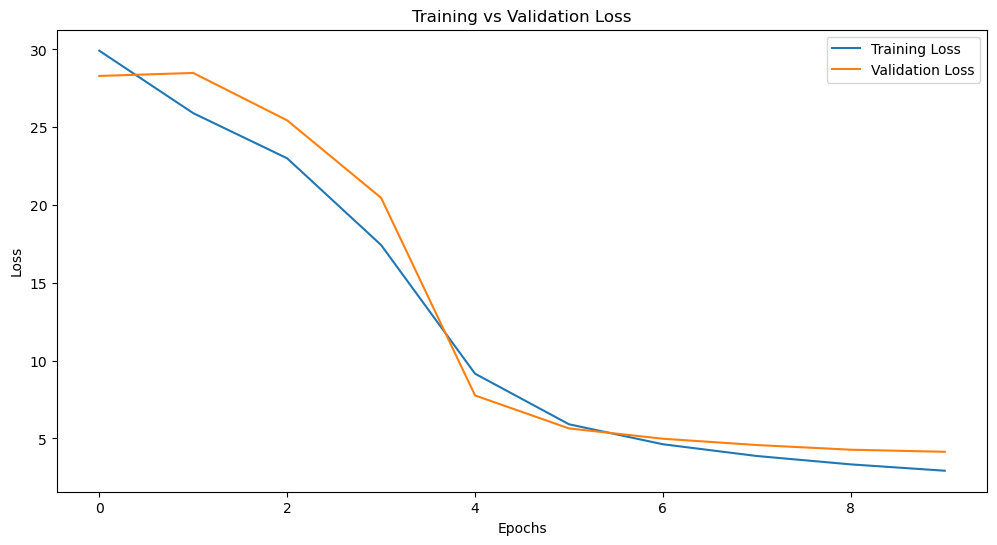

In [52]:
train_loss = [29.9149, 25.9021, 22.9995, 17.4271, 9.1581, 5.9074, 4.6229, 3.8679, 3.3296, 2.9225]
val_loss = [28.2944, 28.4867, 25.4392, 20.4589, 7.7599, 5.6412, 4.9787, 4.5728, 4.2726, 4.1384]

plt.figure(figsize=(12,6))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


### Test the Model

In [4]:
act_model.load_weights('best_model.hdf5')

NameError: name 'act_model' is not defined

In [56]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    w, h = img.shape
    if h > 128 or w > 32:
        return None
    if w < 32:
        add_zeros = np.ones((32-w, h)) * 255
        img = np.vstack((img, add_zeros))
    if h < 128:
        add_zeros = np.ones((32, 128-h)) * 255
        img = np.hstack((img, add_zeros))
    img = np.expand_dims(img, axis=2)
    img = img / 255.

    return img

def predict_image_text(image_path, model, char_list):
    processed_image = preprocess_image(image_path)
    if processed_image is not None:
        prediction = model.predict(np.array([processed_image]))
        out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1], greedy=True)[0][0])
        
        for x in out:
            predicted_text = ''.join([char_list[int(p)] for p in x if int(p) != -1])
            predicted_text = predicted_text.split('jpg')[0] 
            predicted_text = predicted_text.upper()
            return predicted_text
    else:
        return "Image dimensions are not suitable for the model."

def plot_image(image_path):
    img= mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

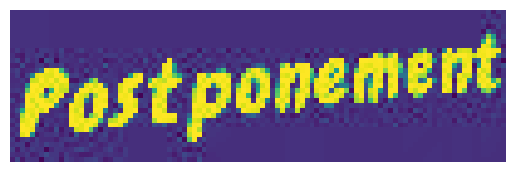

1/1 [==============================] - 0s 106ms/step
POSTPONEMEN


In [58]:
image_path = "C:\\Users\\Saurabh Bhite\\project_Dot\\Test_data\\99956_Postponement.jpg"
plot_image(image_path)
print(predict_image_text(image_path, act_model, char_list))

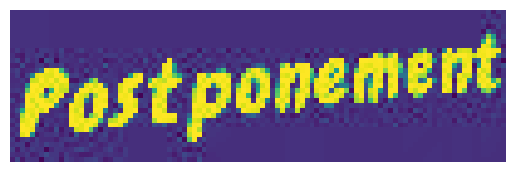

1/1 [==============================] - 0s 110ms/step
POSTPONEMEN


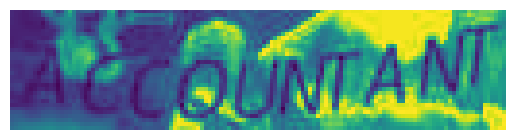

1/1 [==============================] - 0s 96ms/step
ACQUNTANT


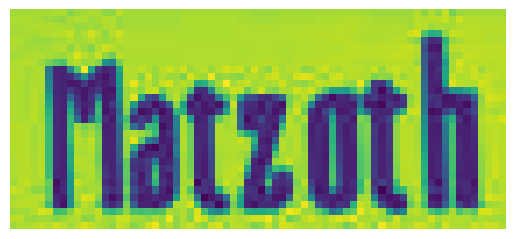

1/1 [==============================] - 0s 91ms/step
MATZOTH


In [60]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    w, h = img.shape
    if h > 128 or w > 32:
        return None
    if w < 32:
        add_zeros = np.ones((32-w, h)) * 255
        img = np.vstack((img, add_zeros))
    if h < 128:
        add_zeros = np.ones((32, 128-h)) * 255
        img = np.hstack((img, add_zeros))
    img = np.expand_dims(img, axis=2)
    img = img / 255.
    return img

def predict_image_text(image_path, model, char_list):
    processed_image = preprocess_image(image_path)
    if processed_image is not None:
        prediction = model.predict(np.array([processed_image]))
        out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1], greedy=True)[0][0])
        
        for x in out:
            predicted_text = ''.join([char_list[int(p)] for p in x if int(p) != -1])
            predicted_text = predicted_text.split('jpg')[0] 
            predicted_text = predicted_text.upper()
            return predicted_text
    else:
        return "Image dimensions are not suitable for the model."

def display_image_and_text(image_path, model, char_list):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    
    print(predict_image_text(image_path, model, char_list))
    
image_paths = [
    "C:\\Users\\Saurabh Bhite\\project_Dot\\Test_data\\99956_Postponement.jpg",
    "C:\\Users\\Saurabh Bhite\\project_Dot\\Test_data\\99977_ACCOUNTANT.jpg",
    "C:\\Users\\Saurabh Bhite\\project_Dot\\Test_data\\99990_Matzoth.jpg",
    "C:\\Users\\Saurabh Bhite\\project_Dot\\Val_data\\8_LEXERS.jpg"
]

for path in image_paths:
    display_image_and_text(path, act_model, char_list)
